Alttaki kodda bize verilen verisetini pandas ile okuyoruz.

In [37]:
import pandas as pd

train_data = pd.read_csv('cure_the_princess_train.csv')
val_data = pd.read_csv('cure_the_princess_validation.csv')
test_data = pd.read_csv('cure_the_princess_test.csv')

Alttaki kodda ise önceden okuduğumuz verisetini numpy ile okuyoruz üzerinde işlem yapabilmek için.

In [38]:
import numpy as np

train_data_np = train_data.to_numpy()
val_data_np = val_data.to_numpy()
test_data_np = test_data.to_numpy()

GPU kullanabilmesi için bütün verileri device ile gpu'ya aktarıyoruz.
En son sütundaki cured değerini labellara aktarıyoruz.
İlk 13 sütundaki değerleri ise inputlara aktarıyoruz.

In [39]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

train_inputs = torch.from_numpy(train_data_np[:, :13]).float().to(device)
train_labels = torch.from_numpy(train_data_np[:, 13]).long().to(device)

val_inputs = torch.from_numpy(val_data_np[:, :13]).float().to(device)
val_labels = torch.from_numpy(val_data_np[:, 13]).long().to(device)

test_inputs = torch.from_numpy(test_data_np[:, :13]).float().to(device)
test_labels = torch.from_numpy(test_data_np[:, 13]).long().to(device)


cuda:0


Alttaki kodda input ve label verilerimizi dataloader ile yüklüyoruz. Batch size 16 bizim için ideal.

In [40]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_inputs, train_labels)
val_dataset = TensorDataset(val_inputs, val_labels)
test_dataset = TensorDataset(test_inputs, test_labels)

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Burada Multi Layer Perceptron sınıfını oluşturduk. Manual seed içine öğrenci numaramı koydum.
Burada ilk hidden layerda 100 nöron var.
İkinci hidden layerda 50 nöron var.
Output layerda ise 1 nöron var, cured değerinin çıktı olması için.

Hidden layerlarda Relu fonksiyonu kullandık.
Output layerda ise sigmoid kullandık.

Sonrasında Binary Cross Entropy Loss kullandık çünkü çıktımız bir binary değer.
Learning rate olarak 0.001 verdim bu değerde iyi bir grafik çıkıyor.

In [41]:
import torch.nn as nn

torch.manual_seed(190401055)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden_layer_1 = nn.Linear(13, 100)
        self.hidden_layer_2 = nn.Linear(100, 50)
        self.output_layer = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden_layer_1(x))
        x = self.relu(self.hidden_layer_2(x))
        x = self.sigmoid(self.output_layer(x))
        return x

model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

Altta modelimizi eğitiyoruz. Epoch olarak 2000 verdim. 
Patience değeri olarak ise 25 verdim.
Sonrasında en iyi modeli kaydediyoruz.

In [42]:
train_losses = []
val_losses = []
num_epochs = 2000
patience = 25
best_val_loss = np.inf
patience_counter = 0
best_model = None

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)
    
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_dataloader.dataset)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping after {epoch + 1} epochs')
                break
    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Patience: {patience_counter}')

torch.save(best_model, 'soru5_model.pt')


Epoch 50/2000, Train Loss: 0.2191, Val Loss: 0.2020, Patience: 0
Epoch 100/2000, Train Loss: 0.1557, Val Loss: 0.1628, Patience: 1
Epoch 150/2000, Train Loss: 0.1203, Val Loss: 0.1420, Patience: 0
Epoch 200/2000, Train Loss: 0.0952, Val Loss: 0.1355, Patience: 3
Early stopping after 222 epochs


Oluşturduğumuz verinin grafiğini seaborn ile oluşturuyoruz.

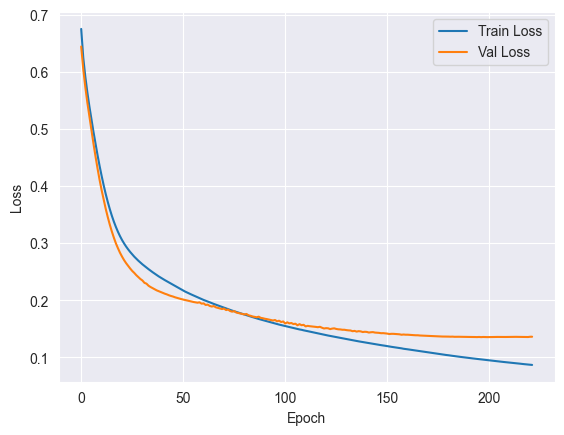

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Burada sklearn kütüphanesi ile modelimizin accuracy, f1, precision ve recall değerlerini hesaplıyoruz.

In [44]:
def accuracy(y_true, y_pred):
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            correct += 1
    return correct / len(y_true)

def precision(y_true, y_pred):
    true_positives = 0
    false_positives = 0
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:
            true_positives += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            false_positives += 1
    if true_positives + false_positives == 0:
        return 0
    else:
        return true_positives / (true_positives + false_positives)

def recall(y_true, y_pred):
    true_positives = 0
    false_negatives = 0
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:
            true_positives += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            false_negatives += 1
    if true_positives + false_negatives == 0:
        return 0
    else:
        return true_positives / (true_positives + false_negatives)

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    if prec + rec == 0:
        return 0
    else:
        return 2 * (prec * rec) / (prec + rec)

test_predictions = []
test_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = torch.round(outputs)
        test_predictions.extend(predicted.detach().cpu().numpy())
        test_labels.extend(labels.detach().cpu().numpy())

accuracy = accuracy(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
precision = precision(test_labels, test_predictions)
recall = recall(test_labels, test_predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


Accuracy: 0.9443
F1 score: 0.9436
Precision: 0.9600
Recall: 0.9278


Alttaki kodda modelin overfit etmesi için early stopping kodunu kaldırdım.

Epoch 100/2000, Train Loss: 0.1557, Val Loss: 0.1628
Epoch 200/2000, Train Loss: 0.0952, Val Loss: 0.1355
Epoch 300/2000, Train Loss: 0.0641, Val Loss: 0.1454
Epoch 400/2000, Train Loss: 0.0458, Val Loss: 0.1637
Epoch 500/2000, Train Loss: 0.0339, Val Loss: 0.1833
Epoch 600/2000, Train Loss: 0.0258, Val Loss: 0.2027
Epoch 700/2000, Train Loss: 0.0204, Val Loss: 0.2177
Epoch 800/2000, Train Loss: 0.0163, Val Loss: 0.2340
Epoch 900/2000, Train Loss: 0.0134, Val Loss: 0.2468
Epoch 1000/2000, Train Loss: 0.0111, Val Loss: 0.2596
Epoch 1100/2000, Train Loss: 0.0094, Val Loss: 0.2701
Epoch 1200/2000, Train Loss: 0.0080, Val Loss: 0.2806
Epoch 1300/2000, Train Loss: 0.0069, Val Loss: 0.2895
Epoch 1400/2000, Train Loss: 0.0059, Val Loss: 0.2964
Epoch 1500/2000, Train Loss: 0.0052, Val Loss: 0.3030
Epoch 1600/2000, Train Loss: 0.0044, Val Loss: 0.3103
Epoch 1700/2000, Train Loss: 0.0039, Val Loss: 0.3163
Epoch 1800/2000, Train Loss: 0.0034, Val Loss: 0.3226
Epoch 1900/2000, Train Loss: 0.0031, 

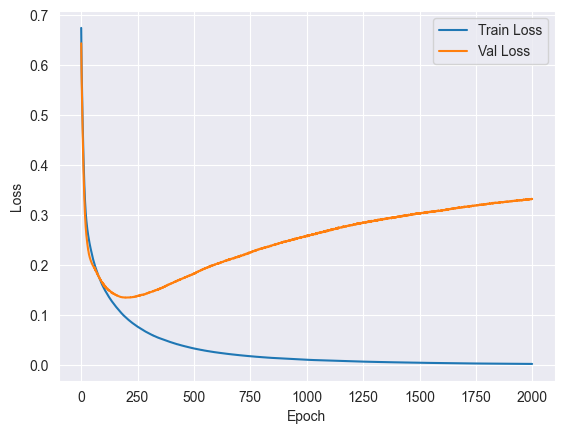

In [45]:
import torch.nn as nn

torch.manual_seed(190401055)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden_layer_1 = nn.Linear(13, 100)
        self.hidden_layer_2 = nn.Linear(100, 50)
        self.output_layer = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden_layer_1(x))
        x = self.relu(self.hidden_layer_2(x))
        x = self.sigmoid(self.output_layer(x))
        return x

model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
num_epochs = 2000
best_val_loss = np.inf

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)
    
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_dataloader.dataset)
        val_losses.append(val_loss)

    # every 100 epochs, print the loss
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

torch.save(model.state_dict(), "soru5_overfit.pt")

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

